# Bank Marketing Dataset
## Predicting Term Deposit Suscriptions

Find the best strategies to improve for the next marketing campaign. How can the financial institution have a greater effectiveness for future marketing campaigns? In order to answer this, we have to analyze the last marketing campaign the bank performed and identify the patterns that will help us find conclusions in order to develop future strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score
import time
from sklearn.cluster import KMeans


Feature/column description

Input variables

* Bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. balance: bank balance
7. housing: has housing loan? (categorical: 'no','yes','unknown')
8. loan: has personal loan? (categorical: 'no','yes','unknown')

* Related with the last contact of the current campaign:
9. contact: contact communication type (categorical: 'cellular','telephone')
10. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
11. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
12. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

* Other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

* Output variable (desired target):
17. deposit - has the client subscribed a term deposit? (binary: 'yes','no')



In [3]:
df_raw_data = pd.read_csv(r'bank.csv')
df_raw_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df = df_raw_data.copy()

In [5]:
# The duration information is not know befor calling that is why is excluded from the analysis.
df=df.drop('duration', axis=1)

In [6]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object

In [7]:
df.describe(include = 'all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
count,11162.000000,11162,11162,11162,11162,11162.000000,11162,11162,11162,11162.000000,11162,11162.000000,11162.000000,11162.000000,11162,11162
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,NaN,no,no,cellular,NaN,may,NaN,NaN,NaN,unknown,no
freq,NaN,2566,6351,5476,10994,NaN,5881,9702,8042,NaN,2824,NaN,NaN,NaN,8326,5873
mean,41.231948,NaN,NaN,NaN,NaN,1528.538524,NaN,NaN,NaN,15.658036,NaN,2.508421,51.330407,0.832557,NaN,NaN
std,11.913369,NaN,NaN,NaN,NaN,3225.413326,NaN,NaN,NaN,8.420740,NaN,2.722077,108.758282,2.292007,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-6847.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,NaN,NaN,122.000000,NaN,NaN,NaN,8.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,550.000000,NaN,NaN,NaN,15.000000,NaN,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,1708.000000,NaN,NaN,NaN,22.000000,NaN,3.000000,20.750000,1.000000,NaN,NaN


In [8]:
df.describe()

,age,balance,day,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,63.000000,854.000000,58.000000


# 1. Data cleaning and feature enginering

### 1.1 How deposit is related with numerical and categorical features

In [9]:
# Numeric features
cols_num = ['age', 'balance', 'day', 'campaign']

In [10]:
print(df.deposit.unique())

['yes' 'no']


Text(0, 0.5, 'count')

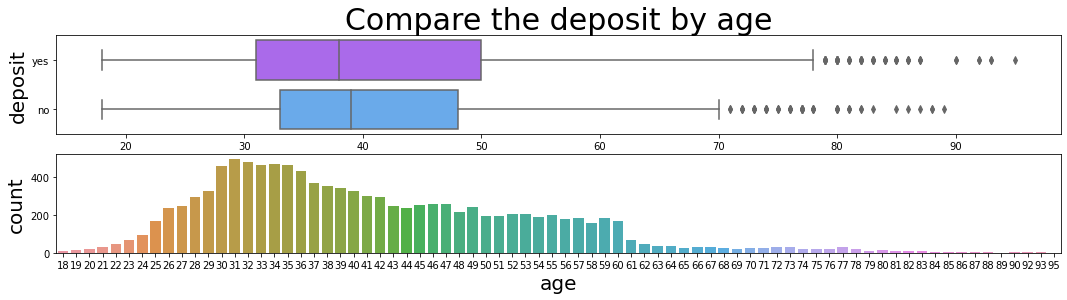

In [11]:
fig, ax = plt.subplots(2,1, figsize=(18, 4))

bplot = sns.boxplot(ax=ax[0], x = 'age', y = 'deposit', data = df, palette="cool_r")
bplot.axes.set_title("Compare the deposit by age",fontsize=30)
bplot.set_ylabel('deposit', fontsize=20)

hist = sns.countplot(ax=ax[1], x = 'age', data = df)
# bar_plot = sns.histplot(ax=ax[1], x='balance', data=df, color="green")
hist.set_xlabel("age",fontsize=20)
hist.set_ylabel("count",fontsize=20)


In [12]:
df.shape

(11162, 16)

Remove outliers.

In [13]:
Q1 = df[df.deposit == 'yes'].age.quantile(0.25)
Q3 = df[df.deposit == 'yes'].age.quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
print(IQR)

filter = (((df.age < (Q1 - 1.5 * IQR)) |(df.age > (Q3 + 1.5 * IQR))) & (df.deposit == 'yes'))
df = df[~filter]
df.shape # afer deleting the filters

19.0


(11097, 16)

In [14]:
Q1 = df[df.deposit == 'no'].age.quantile(0.25)
Q3 = df[df.deposit == 'no'].age.quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (((df.age < (Q1 - 1.5 * IQR)) |(df.age > (Q3 + 1.5 * IQR))) & (df.deposit == 'no'))
df = df[~filter]
df.shape # afer deleting the filters

(11042, 16)

Text(0, 0.5, 'count')

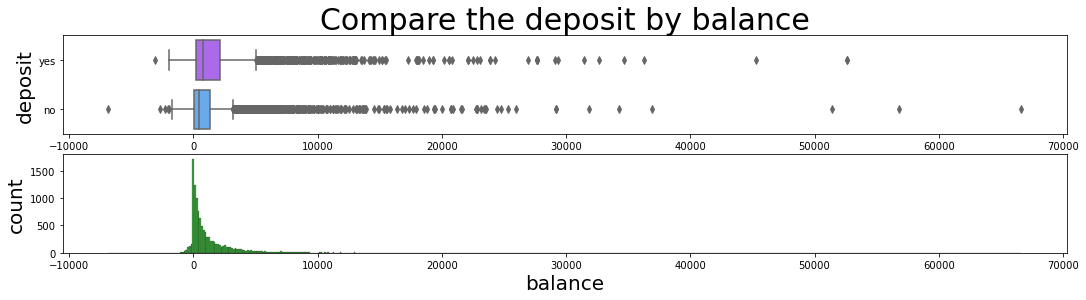

In [15]:
fig, ax = plt.subplots(2,1, figsize=(18, 4))

bplot = sns.boxplot(ax=ax[0], x='balance', y = 'deposit', data=df, palette="cool_r")
bplot.axes.set_title("Compare the deposit by balance",fontsize=30)
bplot.set_ylabel("deposit",fontsize=20)

bar_plot = sns.histplot(ax=ax[1], x='balance', data=df, color="green")
bar_plot.set_xlabel("balance",fontsize=20)
bar_plot.set_ylabel("count",fontsize=20)


Text(0, 0.5, 'count')

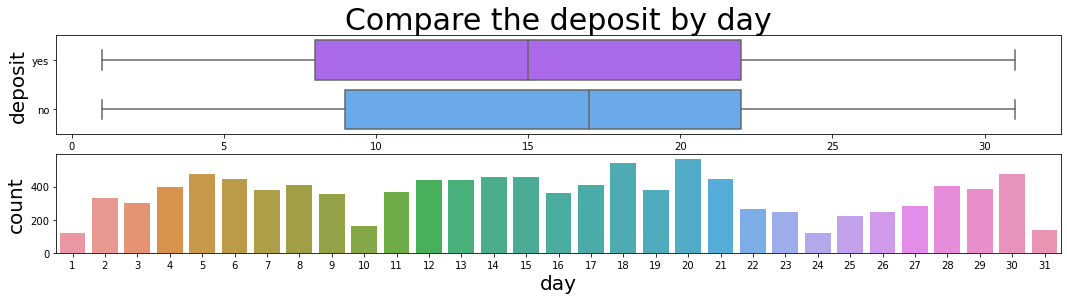

In [16]:
fig, ax = plt.subplots(2,1, figsize=(18, 4))

bplot = sns.boxplot(ax=ax[0], x = 'day', y = 'deposit', data = df, palette="cool_r")
bplot.axes.set_title("Compare the deposit by day",fontsize=30)
bplot.set_ylabel('deposit', fontsize=20)

hist = sns.countplot(ax=ax[1], x = 'day', data = df)
# bar_plot = sns.histplot(ax=ax[1], x='balance', data=df, color="green")
hist.set_xlabel("day",fontsize=20)
hist.set_ylabel("count",fontsize=20)


Text(0, 0.5, 'count')

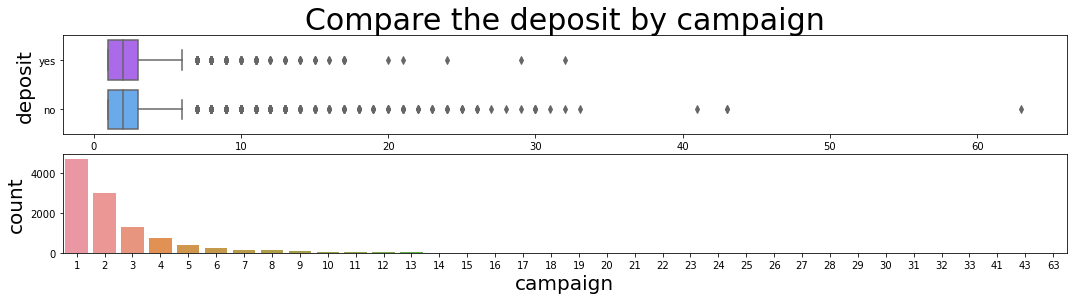

In [17]:
fig, ax = plt.subplots(2,1, figsize=(18, 4))

bplot = sns.boxplot(ax=ax[0], x = 'campaign', y = 'deposit', data = df, palette="cool_r")
bplot.axes.set_title("Compare the deposit by campaign",fontsize=30)
bplot.set_ylabel('deposit', fontsize=20)

hist = sns.countplot(ax=ax[1], x = 'campaign', data = df)
# bar_plot = sns.histplot(ax=ax[1], x='balance', data=df, color="green")
hist.set_xlabel("campaign",fontsize=20)
hist.set_ylabel("count",fontsize=20)


In [18]:
df.shape

(11042, 16)

In [19]:
# remove outliers based on the campain feature
Q1 = df[df.deposit == 'yes'].campaign.quantile(0.25)
Q3 = df[df.deposit == 'yes'].campaign.quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
print(IQR)

filter = (((df.campaign < (Q1 - 1.5 * IQR)) |(df.campaign > (Q3 + 1.5 * IQR))) & (df.deposit == 'yes'))
df = df[~filter]
df.shape # afer deleting the filters


2.0


(10883, 16)

In [20]:
# remove outliers based on the campain feature
Q1 = df[df.deposit == 'no'].campaign.quantile(0.25)
Q3 = df[df.deposit == 'no'].campaign.quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
print(IQR)

filter = (((df.campaign < (Q1 - 1.5 * IQR)) |(df.campaign > (Q3 + 1.5 * IQR))) & (df.deposit == 'no'))
df = df[~filter]
df.shape # afer deleting the filters

2.0


(10444, 16)

In [21]:
# I had to chanche 
df['pdays'] = df['pdays'].replace(-1, 0)

Text(0, 0.5, 'count')

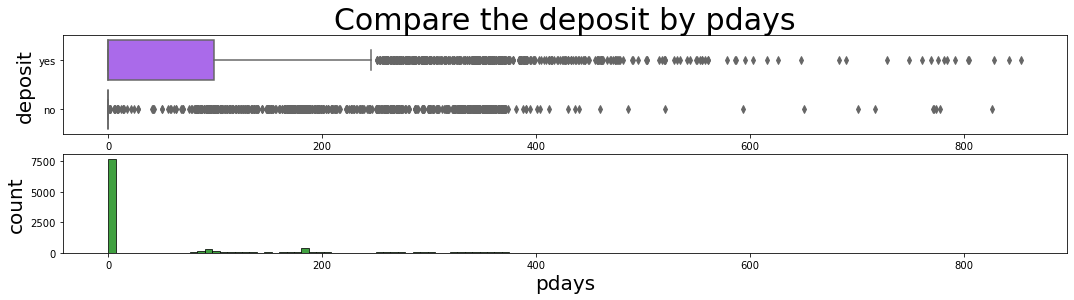

In [22]:
fig, ax = plt.subplots(2,1, figsize=(18, 4))

bplot = sns.boxplot(ax=ax[0], x='pdays', y = 'deposit', data=df, palette="cool_r")
bplot.axes.set_title("Compare the deposit by pdays",fontsize=30)
bplot.set_ylabel("deposit",fontsize=20)

bar_plot = sns.histplot(ax=ax[1], x='pdays', data=df, color="green")
bar_plot.set_xlabel("pdays",fontsize=20)
bar_plot.set_ylabel("count",fontsize=20)


Text(0, 0.5, 'count')

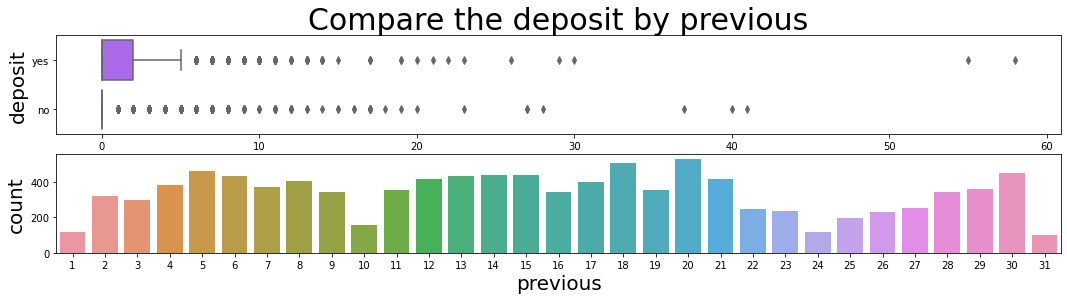

In [23]:
fig, ax = plt.subplots(2,1, figsize=(18, 4))

bplot = sns.boxplot(ax=ax[0], x = 'previous', y = 'deposit', data = df, palette="cool_r")
bplot.axes.set_title("Compare the deposit by previous",fontsize=30)
bplot.set_ylabel('deposit', fontsize=20)

hist = sns.countplot(ax=ax[1], x = 'day', data = df)
# bar_plot = sns.histplot(ax=ax[1], x='balance', data=df, color="green")
hist.set_xlabel("previous",fontsize=20)
hist.set_ylabel("count",fontsize=20)

From the visualization of numerical variable we saw:

1. age - we excluded the outliers. 
2. balance - should be compared with the day, and how it changes during the month/year. Moreover, this tells how much the person can invest. 
3. campaign - we excluded the outliers. The number of contacts with the person should be reduced to the minimum during the campaign.
4. pdays - the contact mostly appear at the beginning of the period and is unusual to make a contact after 400 days.
5. previous - we need to take a look at the clients who were in the previous campaigns.


In [24]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,0,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,0,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,0,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,0,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,0,0,unknown,yes


1.2. Correlation matrix for numerical values

<AxesSubplot:>

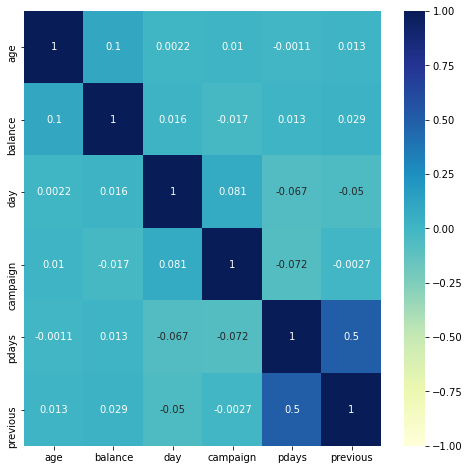

In [25]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), vmin = -1, vmax = 1,cmap="YlGnBu", annot=True)

We are not able to see all correlation, we need to change also the categorical features to have more broad overwiew. 

Categorical feature distribution.

In [26]:
# Categorical and binary features
columns_cat = ['job', 'marital', 'education', 'contact', 'month', 'default', 'housing', 'loan']

In [27]:
for en, i in enumerate(columns_cat):
    print('Categorical name: ',columns_cat[en])
    print('Unique values: ',df[i].unique())

Categorical name:  job
Unique values:  ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
Categorical name:  marital
Unique values:  ['married' 'single' 'divorced']
Categorical name:  education
Unique values:  ['secondary' 'tertiary' 'primary' 'unknown']
Categorical name:  contact
Unique values:  ['unknown' 'cellular' 'telephone']
Categorical name:  month
Unique values:  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Categorical name:  default
Unique values:  ['no' 'yes']
Categorical name:  housing
Unique values:  ['yes' 'no']
Categorical name:  loan
Unique values:  ['no' 'yes']


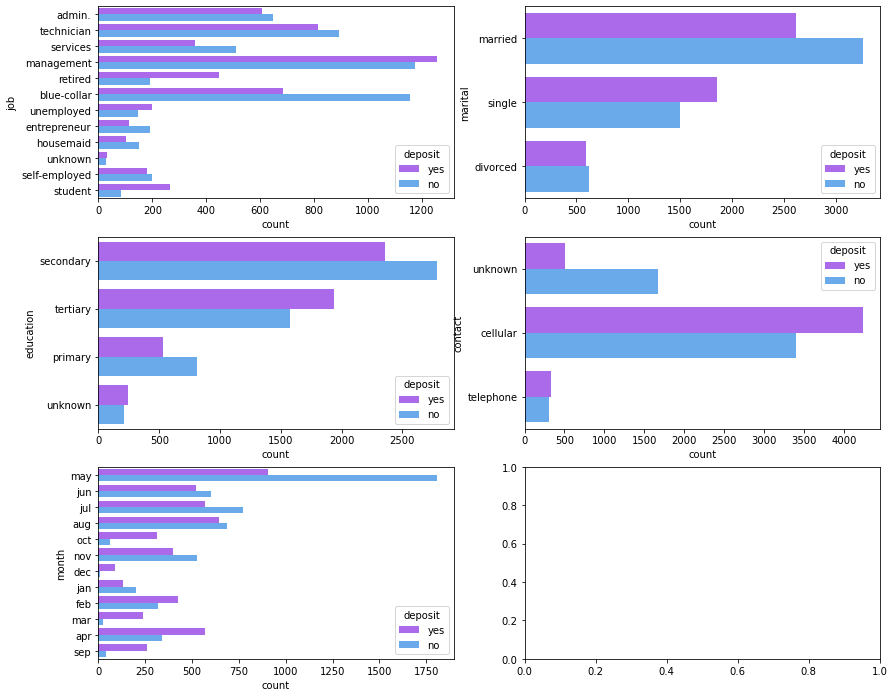

In [32]:
f, axes = plt.subplots(3, 2, figsize=(14,12))

hist1 = sns.countplot(y = 'job', hue = 'deposit', data = df, palette="cool_r", ax=axes[0][0])

hist2 = sns.countplot(y = 'marital', hue = 'deposit', data = df, palette="cool_r", ax=axes[0][1])

hist3 = sns.countplot(y = 'education', hue = 'deposit', data = df, palette="cool_r", ax=axes[1][0])

hist7 = sns.countplot(y = 'contact', hue = 'deposit', data = df, palette="cool_r", ax=axes[1][1])

hist8 = sns.countplot(y = 'month', hue = 'deposit', data = df, palette="cool_r", ax=axes[2][0])

We could see that:
* The campaign were more for professions such as management, technician and blue-collar that is why we know a lot how many of them have/have not deposit.
* Married people hold the most deposit while divorce the lowest. This feature can be more investigate. 
* We saw also that the contacts were the most in May, June and July which can be not relevant for campaigns. We should consider to change the contact month. 

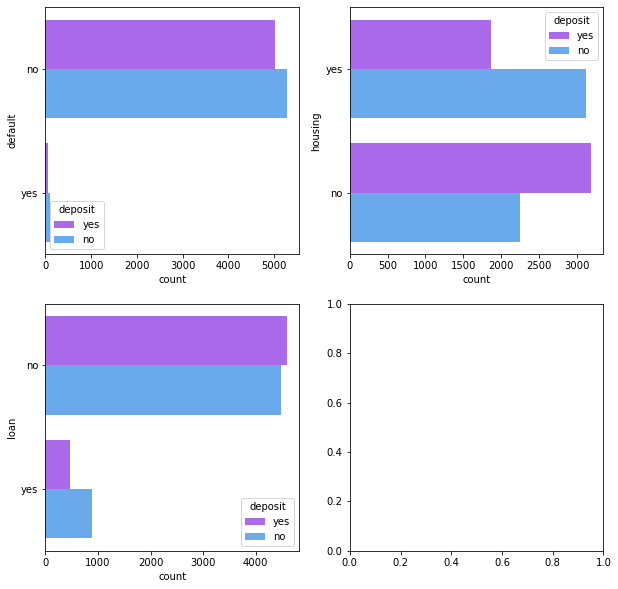

In [29]:
f, axes = plt.subplots(2, 2, figsize=(10,10))

hist4 = sns.countplot(y = 'default', hue = 'deposit', data = df, palette="cool_r", ax=axes[0][0])

hist5 = sns.countplot(y = 'housing', hue = 'deposit', data = df, palette="cool_r", ax=axes[0][1])

hist6 = sns.countplot(y = 'loan', hue = 'deposit', data = df, palette="cool_r", ax=axes[1][0])

We see that:
* people with the default (credit) is far less than without; we can exclude with default from the analysis;



## 2. Pre-processing and standarization  data

2.1. Convertseries data to numerical values

In [33]:
df = df.replace(['yes','no'], [1,0])

In [34]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1,0,0,unknown,1
1,56,admin.,married,secondary,0,45,0,0,unknown,5,may,1,0,0,unknown,1
2,41,technician,married,secondary,0,1270,1,0,unknown,5,may,1,0,0,unknown,1
3,55,services,married,secondary,0,2476,1,0,unknown,5,may,1,0,0,unknown,1
4,54,admin.,married,tertiary,0,184,0,0,unknown,5,may,2,0,0,unknown,1


In [31]:
df_categorical = df[columns_cat]
df_categorical.head()

,job,marital,education,contact,month,default,housing,loan
0,admin.,married,secondary,unknown,may,0,1,0
1,admin.,married,secondary,unknown,may,0,0,0
2,technician,married,secondary,unknown,may,0,1,0
3,services,married,secondary,unknown,may,0,1,0
4,admin.,married,tertiary,unknown,may,0,0,0


In [35]:
df_numerical = pd.get_dummies(df)
df_numerical.shape

(10444, 48)

In [36]:
df_numerical.head()

,age,default,balance,housing,loan,day,campaign,pdays,previous,deposit,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,2343,1,0,5,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,56,0,45,0,0,5,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,41,0,1270,1,0,5,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,55,0,2476,1,0,5,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,54,0,184,0,0,5,2,0,0,1,...,0,0,1,0,0,0,0,0,0,1


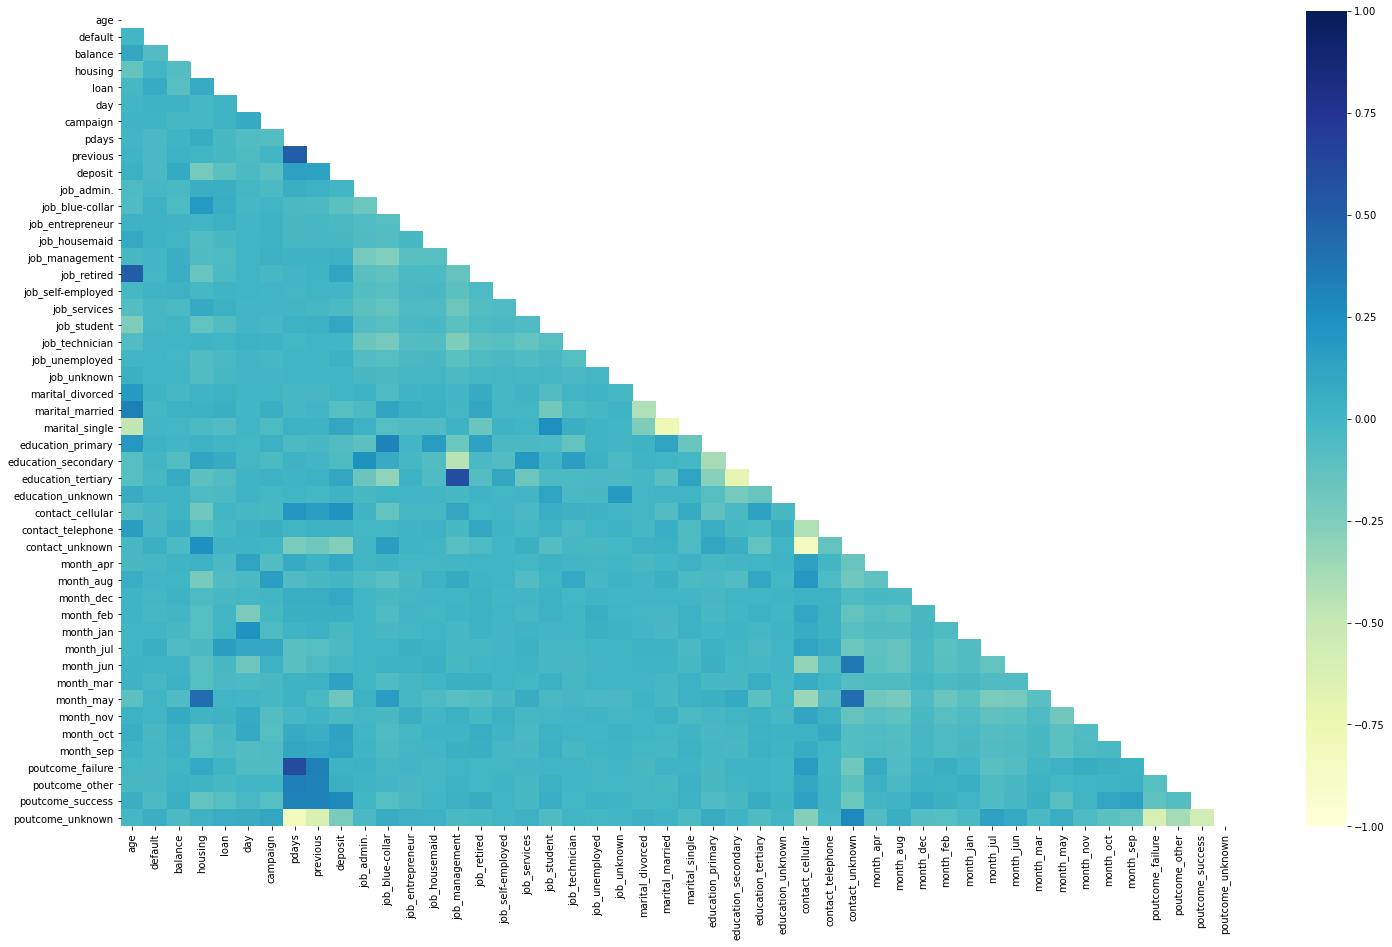

In [62]:
plt.figure(figsize=(25,15))
mask = np.triu(np.ones_like(df_numerical.corr(), dtype=np.bool))

heatmap = sns.heatmap(df_numerical.corr(), vmin = -1, vmax = 1,cmap="YlGnBu", annot=False, mask=mask)


2.2. Standarized data

In [37]:
X = df_numerical.drop('deposit', axis=1)
Y = df_numerical['deposit']

In [38]:
scaler = StandardScaler()
Standard_data  = scaler.fit_transform(X)

In [39]:
X = Standard_data
print(X)
print(Y)

[[ 1.60971465 -0.12112045  0.27885359 ... -0.22611328 -0.33273014
   0.59740463]
 [ 1.34438154 -0.12112045 -0.48763284 ... -0.22611328 -0.33273014
   0.59740463]
 [ 0.01771597 -0.12112045 -0.0790402  ... -0.22611328 -0.33273014
   0.59740463]
 ...
 [-0.77828337 -0.12112045 -0.49296956 ... -0.22611328 -0.33273014
   0.59740463]
 [ 0.19460472 -0.12112045 -0.50264236 ... -0.22611328 -0.33273014
  -1.67390734]
 [-0.60139462 -0.12112045 -0.50264236 ... -0.22611328 -0.33273014
   0.59740463]]
0        1
1        1
2        1
3        1
4        1
        ..
11157    0
11158    0
11159    0
11160    0
11161    0
Name: deposit, Length: 10444, dtype: int64


2.3. Split data into training and test data sets. 

"stratify" parameter is for considering approximately the same percentage of samples of each target class  

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y)

In [96]:
skf = StratifiedKFold(n_splits=5, random_state=None)

# Baseline models
baseline_model_dict = {}

In [121]:
# k-Nearest Neighbour
knn = KNeighborsClassifier()
knn_results = cross_val_score(knn, X, Y, cv=skf)
print("KNN Accuracy: %.2f%%" % (knn_results.mean() * 100.0))
baseline_model_dict['KNN'] = knn_results.mean() * 100.0

KNN Accuracy: 63.64%


In [107]:
# Logistic Regression
lr = LogisticRegression()
lr_results = cross_val_score(lr, X, Y, cv=skf)
print("LogReg Accuracy: %.2f%%" % (lr_results.mean() * 100.0))
baseline_model_dict['LogReg'] = lr_results.mean() * 100.0

LogReg Accuracy: 65.11%


In [125]:
# model = LogisticRegression()
lr.fit(X_train, Y_train)
lr.score(X_test ,Y_test)
pred_lr=lr.predict(X_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# print(accuracy_score(Y_test,pred_lr))
print(classification_report(Y_test,pred_lr))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1614
           1       0.74      0.58      0.65      1520

    accuracy                           0.69      3134
   macro avg       0.70      0.69      0.69      3134
weighted avg       0.70      0.69      0.69      3134



In [108]:
# Support Vector Classifier
svc = SVC()
svc_results = cross_val_score(svc, X, Y, cv=skf)
print("SVC Accuracy: %.2f%%" % (svc_results.mean() * 100.0))
baseline_model_dict['SVC'] = svc_results.mean() * 100.0

SVC Accuracy: 68.59%


In [109]:
# Naive Bayes
nb = GaussianNB()
nb_results = cross_val_score(nb, X, Y, cv=skf)
print("NB Accuracy: %.2f%%" % (nb_results.mean() * 100.0))
baseline_model_dict['NB'] = nb_results.mean() * 100.0

NB Accuracy: 66.15%


In [110]:
# Decision Tree
tree = DecisionTreeClassifier()
tree_results = cross_val_score(tree, X, Y, cv=skf)
print("Decision Tree Accuracy: %.2f%%" % (tree_results.mean() * 100.0))
baseline_model_dict['Decision Tree'] = tree_results.mean() * 100.0

Decision Tree Accuracy: 59.87%


In [111]:
# Random Forest
rf = RandomForestClassifier()
rf_results = cross_val_score(rf, X, Y, cv=skf)
print("Random Forest Accuracy: %.2f%%" % (rf_results.mean() * 100.0))
baseline_model_dict['Random Forest'] = rf_results.mean() * 100.0

Random Forest Accuracy: 68.08%


In [112]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc_results = cross_val_score(gbc, X, Y, cv=skf)
print("GBC Accuracy: %.2f%%" % (gbc_results.mean() * 100.0))
baseline_model_dict['GBC'] = gbc_results.mean() * 100.0

GBC Accuracy: 69.56%


In [113]:
print(baseline_model_dict)

{'NB': 66.15286420935055, 'Decision Tree': 59.87217756208858, 'Random Forest': 68.0776517756759, 'GBC': 69.56191343453851, 'KNN': 63.64451450674855, 'LogReg': 65.10948152060878, 'SVC': 68.58517246881586}


<ipython-input-153-77d6c568f37c>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(keys)


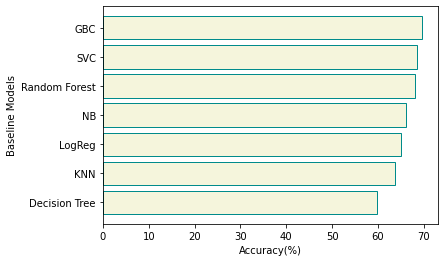

In [153]:
# Plot Baseline Model Accuracies
import operator
sorted_models = sorted(baseline_model_dict.items(), key=operator.itemgetter(1))


keys = []
values = []
for i in range(len(sorted_models)):
    keys.append(sorted_models[i][0])
    values.append(sorted_models[i][1])
    
fig1, ax1 = plt.subplots()
ax1.barh(keys, values, color = 'beige', edgecolor='darkcyan')
ax1.set_ylabel('Baseline Models')
ax1.set_xlabel('Accuracy(%)')
ax1.set_yticklabels(keys)
plt.show()

The model Gradient Boosting Classifier is with the highest accuracy. However this accuracy is significantly low and we have to consider how to rebuild the model to received it higher. 
It seams that there are some features which can give unclear view. In the next step we should dive more into dataset.